In [3]:
# import libraries
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import pandas as pd
import librosa

## Obtaining GTZAN dataset

We will be using `deeplake` to get the GTZAN dataset

In [11]:
from IPython.display import clear_output
# deep lake is not part of google colab by default
!pip3 install deeplake

clear_output()

In [12]:
# setting up the deeplake environment, so that we could download it
import os
os.environ['DEEPLAKE_DOWNLOAD_PATH']='./'

In [13]:
import deeplake
ds = deeplake.load("hub://activeloop/gtzan-genre", access_method="local")

-

Opening dataset in read-only mode as you don't have write permissions.


Copying dataset: 0%|          | 0/102 [00:00<?
Copying dataset: 1%|          | 1/102 [00:12<21:10
Copying dataset: 2%|▏         | 2/102 [00:28<24:31
Copying dataset: 3%|▎         | 3/102 [00:36<19:06
Copying dataset: 4%|▍         | 4/102 [00:55<23:54
Copying dataset: 5%|▍         | 5/102 [01:09<22:48
Copying dataset: 6%|▌         | 6/102 [01:22<22:16
Copying dataset: 7%|▋         | 7/102 [01:36<22:04
Copying dataset: 8%|▊         | 8/102 [01:44<18:58
Copying dataset: 9%|▉         | 9/102 [01:53<17:05
Copying dataset: 10%|▉         | 10/102 [01:59<14:26
Copying dataset: 11%|█         | 11/102 [02:13<16:38
Copying dataset: 12%|█▏        | 12/102 [02:30<19:12
Copying dataset: 13%|█▎        | 13/102 [02:40<17:34
Copying dataset: 14%|█▎        | 14/102 [02:57<19:29
Copying dataset: 15%|█▍        | 15/102 [03:10<19:13
Copying dataset: 16%|█▌        | 16/102 [03:25<20:00
Copying dataset: 17%|█▋        | 17/102 [03:43<21:18
Copying dataset: 18%|█▊        | 18/102 [03:59<21:32
Copying dataset: 

./hub_activeloop_gtzan-genre loaded successfully.



## Creating Spectrograms

In [22]:
def get_spectrograms():

  audio_file = '/content/file_example_WAV_1MG.wav'
  audio, sample_rate = librosa.load(audio_file, sr=None)
  spectrogram = librosa.stft(audio)
  spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Spectrogram')
  plt.show()

get_spectrograms()

C:\Users\Jack\AppData\Local\Temp\ipykernel_18744\2505873893.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(audio_file, sr=None)
c:\Users\Jack\.conda\envs\aps360\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/file_example_WAV_1MG.wav'

## Creating Mel-Spectrograms

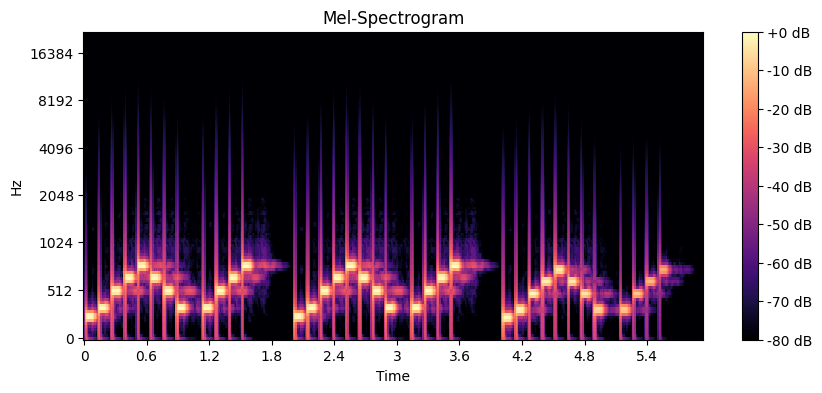

In [ ]:
def get_mel_spectrograms():

  audio_file = '/content/file_example_WAV_1MG.wav'
  audio, sample_rate = librosa.load(audio_file, sr=None)
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel-Spectrogram')
  plt.show()

get_mel_spectrograms()

In [12]:
def extract_features_mfcc(file_name):
    """
    Extract MFCC features from audio file

    Args:
        file_name (str): path to audio file
    Returns:
        mfccs (np.array): MFCC features
    """
    try:
        num_mfcc = 40
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=num_mfcc)
        mfccs = mfccs[:, 0:num_mfcc]
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    return mfccs

# save mfcc features to an image
import matplotlib.pyplot as plt

def save_mfcc_image(mfccs, file_name):
    """
    Save MFCC features as an image

    Args:
        mfccs (np.array): MFCC features
        file_name (str): path to save image
    """
    if mfccs is None:
        return
    plt.figure(figsize=(10, 4), frameon=False)
    librosa.display.specshow(mfccs)
    plt.tight_layout()
    plt.savefig(file_name)
    plt.cla()
    plt.close()

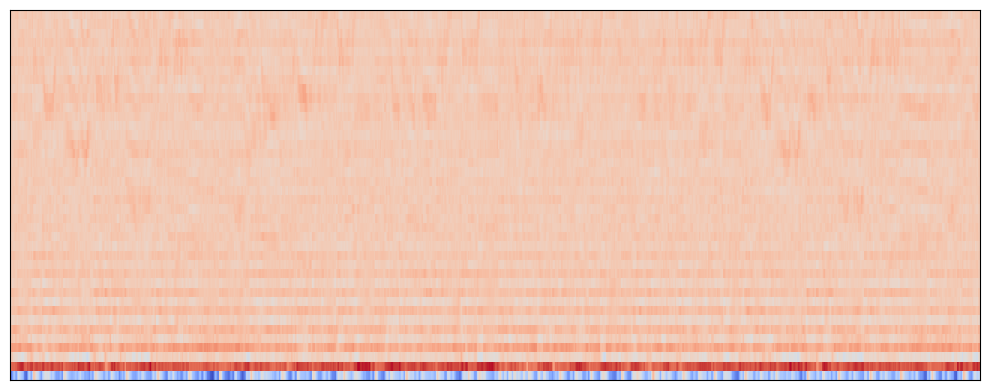

In [24]:
mfcc = extract_features_mfcc('Data/genres_original/blues/blues.00000.wav')
plt.figure(figsize=(10, 4), frameon=False)
librosa.display.specshow(mfccs)
plt.tight_layout()
plt.show()

## Chroma Features

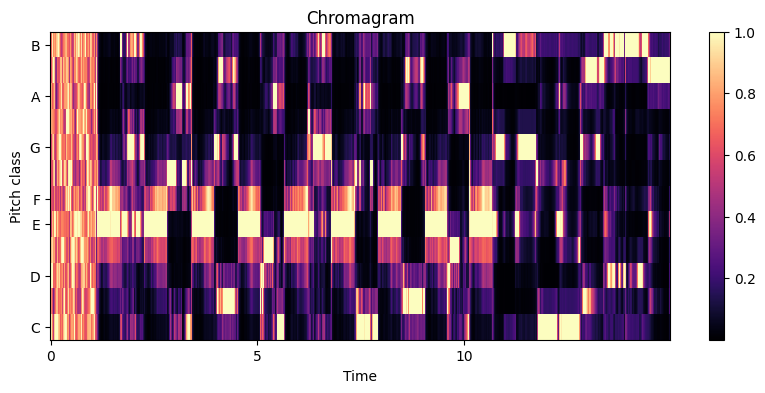

In [30]:
def get_chroma():

  audio, sample_rate = librosa.load(librosa.ex('nutcracker'), duration=15)
  chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)

  plt.figure(figsize=(10, 4))
  librosa.display.specshow(chroma, sr=sample_rate, x_axis='time', y_axis='chroma')
  plt.colorbar()
  plt.title('Chromagram')
  plt.show()

get_chroma()

## Preprocessing

We will first divide each audio file into 3 second sound bits, then preprocess the sound bits into feature images

In [15]:
def convert_to_mfcc_images(data_dir):
    """
    Converts the WAV files to MFCC features and saves them as images in a new directory structure.

    Args:
        data_dir (str): path to data directory
    """
    parent_dir = os.path.dirname(data_dir)
    processed_data_dir = os.path.join(parent_dir, 'mfcc')
    os.makedirs(processed_data_dir, exist_ok=True)
    
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for dirname in dirnames:
            child_folder_path = os.path.join(dirpath, dirname)
            new_dir = os.path.join(processed_data_dir, dirname)
            os.makedirs(new_dir, exist_ok=True)
            for file in os.listdir(child_folder_path):
                # Do something with the file
                file_path = os.path.join(child_folder_path, file)
                mfccs = extract_features_mfcc(file_path)
                image_path = os.path.join(new_dir, f"{os.path.basename(file_path)}.png")
                save_mfcc_image(mfccs, image_path)
    
    print(f"Processed mfcc data saved in {processed_data_dir}")

def convert_to_mel_spectrogram_images(data_dir):
    """
    Converts the WAV files to Mel Spectrogram features and saves them as images in a new directory structure.

    Args:
        data_dir (str): path to data directory
    """
    pass

def convert_to_chroma_images(data_dir):
    """
    Converts the WAV files to Chroma features and saves them as images in a new directory structure.

    Args:
        data_dir (str): path to data directory
    """
    pass

def convert_to_spectrogram_images(data_dir):
    """
    Converts the WAV files to Spectrogram features and saves them as images in a new directory structure.

    Args:
        data_dir (str): path to data directory
    """
    pass

def preprocess(data_dir):
    """
    Preprocess the data

    Args:
        data_dir (str): path to data directory. Assume that the data_dir has the following structure:
            data_dir
            ├── genre1
            │   ├── file1.wav
            │   ├── file2.wav
            │   └── ...
    """
    
    # TODO: Add function call to split audio files into 3 second clips
    # TODO: Add function call to convert audio files to features
    convert_to_spectrogram_images(data_dir)
    convert_to_mel_spectrogram_images(data_dir)
    convert_to_chroma_images(data_dir)
    convert_to_mfcc_images(data_dir)

In [16]:
preprocess('Data/genres_original')

C:\Users\Jack\AppData\Local\Temp\ipykernel_3420\4269474788.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_name)


Error encountered while parsing file:  Data/genres_original\jazz\jazz.00054.wav
Processed mfcc data saved in Data\mfcc


## DataHandler

This class handles data loading, and creates data loaders

In [26]:
class DataHandler:
    def __init__(self, data_dir, batch_size, train_ratio=0.7, val_ratio=0.15, num_workers=0):
        """
        DataHandler class to handle the data loading, preprocessing, and creates data loaders

        Args:
            data_dir (str): path to the data directory
            batch_size (int): batch size
            train_ratio (float): ratio of training data, default=0.7
            val_ratio (float): ratio of validation data, default=0.15
            num_workers (int): number of workers for data loading, default=0
        """
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.num_workers = num_workers

        self.train_loader, self.val_loader, self.test_loader = self._create_data_loaders()

    def _create_data_loaders(self):
        # define the data transformations
        data_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5),
                                    (0.5, 0.5, 0.5))
            ])
        dataset = torchvision.datasets.ImageFolder(self.data_dir, transform=data_transform)
        num_samples = len(dataset)
        
        train_size = int(num_samples * self.train_ratio)
        val_size = int(num_samples * self.val_ratio)
        test_size = num_samples - train_size - val_size
        
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        
        return train_loader, val_loader, test_loader

In [27]:
mfcc_data_dir = 'Data/mfcc'
mfcc_data_handler = DataHandler(mfcc_data_dir, batch_size=32, num_workers=4)